In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as D
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import math
import os
import argparse
from functools import partial
from torch.nn import Sequential as Sq



_ln2 = 0.6931471805599453

def std_fn(x, beta=_ln2):
    return F.softplus(x, beta=beta).clamp_min(1e-5)

def std_fn_inv(x, beta=_ln2, safe=True):
    x = (beta * x)
    x = torch.where(x > 0.1, x.exp() - 1, x.expm1()) if safe else x.exp() - 1
    return x.log() / beta


class Normal(object):
    def __init__(self, loc, std):
        self.loc, self.std = loc, std
        assert std.min() >= 0.

    def log_prob(self, x):
        log_prob = - 0.5 * np.log(2 * np.pi) - self.std.log() - 0.5 * ((x - self.loc) / self.std).square()
        return log_prob
        
    def sample(self):
        return self.loc + torch.randn_like(self.std) * self.std
    
    def sample_given_eps(self, eps):
        return self.loc + eps * self.std

    @staticmethod
    def kld(q, p):
        return p.std.log() - q.std.log() + 0.5 * ((q.std / p.std).square() + ((q.loc - p.loc) / p.std).square()) - 0.5


class SwissRoll(torch.utils.data.Dataset):
    def __init__(self, n_samples=100000, noise=0.5):
        from sklearn.datasets import make_swiss_roll
        x = make_swiss_roll(n_samples=n_samples, noise=0.5)[0][:,[0, 2]]
        xmin, xmax = x.min(axis=0)[0], x.max(axis=0)[0]
        x = (x - xmin) / (xmax - xmin)
        self.x = torch.FloatTensor(2. * x - 1.)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx]

class Parameter(nn.Module):
    def __init__(self, *shape, init_scale=1., requires_grad=True):
        super().__init__()
        self.shape = shape
        self.param = torch.randn(*shape).unsqueeze(0)
        nn.init.kaiming_uniform_(self.param, nonlinearity='linear')
        self.param = nn.Parameter(self.param * init_scale, requires_grad)
    
    def forward(self, b):
        b = b if isinstance(b, int) else b.size()[0]
        return self.param.expand(b, *self.shape)



def requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag

In [4]:
def get_mlp(i, o, h):
    return Sq(nn.Linear(i, h), nn.SiLU(inplace=True), nn.Linear(h, h), nn.SiLU(inplace=True), nn.Linear(h, o))

def get_mlp_big(i, o, h):
    return Sq(nn.Linear(i, h), nn.SiLU(inplace=True), nn.Linear(h, h), nn.SiLU(inplace=True), 
              nn.Linear(h, h), nn.SiLU(inplace=True), nn.Linear(h, o))
     

In [5]:
class VAE(nn.Module):
    def __init__(self, x_dim=2, z_dim=2, hidden_dim=256):
        super().__init__()
        self.x_dim, self.z_dim = x_dim, z_dim
        self.enc = Sq(nn.Linear(x_dim, hidden_dim),
                      nn.SiLU(inplace=True),
                      nn.Linear(hidden_dim, hidden_dim),
                      nn.SiLU(inplace=True),
                      nn.Linear(hidden_dim, 2 * z_dim))
        
        self.dec = Sq(nn.Linear(z_dim, hidden_dim),
                      nn.SiLU(inplace=True),
                      nn.Linear(hidden_dim, hidden_dim),
                      nn.SiLU(inplace=True),
                      nn.Linear(hidden_dim, 2 * x_dim))


    def forward(self, x):
        qz_loc, qz_std = self.enc(x).chunk(2, 1)
        qz = Normal(qz_loc, std_fn(qz_std))

        pz_loc = torch.zeros_like(qz_loc)
        pz = Normal(pz_loc, torch.ones_like(qz_std))

        z = qz.sample()
        px_loc, px_std = self.dec(z).chunk(2, 1)
        px = Normal(px_loc, std_fn(px_std))
        kld = Normal.kld(qz, pz).mean(dim=0).sum()
        return px, kld

    def sample(self, batch_size):
        pz = Normal(torch.zeros(batch_size, self.z_dim), torch.ones(batch_size, self.z_dim))
        z = pz.sample()
        px_loc, px_std = self.dec(z).chunk(2, 1)
        px = Normal(px_loc, std_fn(px_std))
        return px


In [6]:

def vae_given_eps(vae, eps):
    batch_size = eps[0].size()[0]
    pz = Normal(torch.zeros(batch_size, vae.z_dim), torch.ones(batch_size, vae.z_dim))
    z = pz.sample_given_eps(eps[0])
    px_loc, px_std = vae.dec(z).chunk(2, 1)
    px = Normal(px_loc, std_fn(px_std))
    x = px.sample_given_eps(eps[1])
    return x, z, pz, px


In [7]:
args = argparse.Namespace()
args.device  = 'cuda' if torch.cuda.is_available() else 'cpu'
vae = VAE().to(args.device)
vae_optimizer = optim.Adamax(vae.parameters(), lr=1e-3)
dataset = SwissRoll()

In [8]:
loader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

for epoch in range(20):
    stats = {'log_pxz': 0., 'all_kld': 0.}
    for x in loader:
        x = x.to(args.device)
        vae_optimizer.zero_grad()
        px, kld = vae(x)

        log_pxz = px.log_prob(x).mean(dim=0).sum()

           
        loss = - log_pxz + kld
        loss.backward()
        vae_optimizer.step()
        stats['log_pxz'] += log_pxz.item() / len(loader)
        stats['all_kld'] += kld.item() / len(loader)
    print(epoch, stats)


0 {'log_pxz': -0.5643413352485516, 'all_kld': 0.9167618485669651}
1 {'log_pxz': 0.7275824407532943, 'all_kld': 2.052342009910701}
2 {'log_pxz': 1.0870286839109082, 'all_kld': 2.355807870664606}
3 {'log_pxz': 1.5030099821304381, 'all_kld': 2.721292450547063}
4 {'log_pxz': 1.8016168515599777, 'all_kld': 2.9685770286945963}
5 {'log_pxz': 2.002613205610563, 'all_kld': 3.122759562601051}
6 {'log_pxz': 2.108539157273978, 'all_kld': 3.184743861382806}
7 {'log_pxz': 2.1762112904144444, 'all_kld': 3.2170297147064595}
8 {'log_pxz': 2.2517332624686945, 'all_kld': 3.268618663660849}
9 {'log_pxz': 2.3047358493646177, 'all_kld': 3.293819168618334}
10 {'log_pxz': 2.3671919200545526, 'all_kld': 3.341220135267503}
11 {'log_pxz': 2.3909038489973025, 'all_kld': 3.3558705588766893}
12 {'log_pxz': 2.4474665569129597, 'all_kld': 3.382752650525903}
13 {'log_pxz': 2.5406835924800597, 'all_kld': 3.4491197965209177}
14 {'log_pxz': 2.5439133280828585, 'all_kld': 3.4410254390535817}
15 {'log_pxz': 2.6172907755408

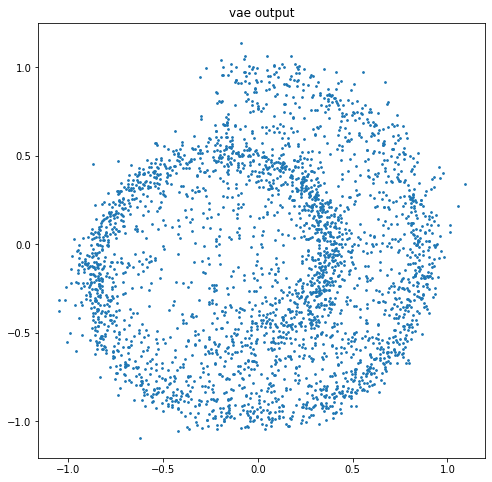

In [10]:
px = vae.sample(3000)
x = px.sample().detach().cpu().numpy()
plt.figure(figsize=(8, 8))
plt.title('vae output')
plt.scatter(x[:, 0], x[:, 1], s=3)
plt.show()

In [11]:
class EBM(nn.Module):
    def __init__(self, x_dim=2, hidden_dim=256):
        super().__init__()
        self.net = Sq(nn.Linear(x_dim, hidden_dim),
                      nn.SiLU(inplace=True),
                      nn.Linear(hidden_dim, hidden_dim),
                      nn.SiLU(inplace=True),
                      nn.Linear(hidden_dim, hidden_dim),
                      nn.SiLU(inplace=True),
                      nn.Linear(hidden_dim, 1))

    def forward(self, x):
        return self.net(x)


In [12]:
def sample_vae(batch_size, ebm, vae, num_steps=5, step_size=1e-3):

    requires_grad(ebm, False)


    eps = [torch.randn(batch_size, 2), torch.randn(batch_size, 2)]

    for i in range(2):
        eps[i] = eps[i].to(args.device)
        eps[i].requires_grad_(True)

    for k in range(num_steps):        

        x, z, pz, px = vae_given_eps(vae, eps)

        dis_neg = ebm(x).sigmoid() # energy is unstable so i use normalized prob log_p(x=True)
        dis_neg_log = dis_neg.log().mean(dim=0).sum()
        log_pz = pz.log_prob(z).mean(dim=0).sum()
        log_px = px.log_prob(x).mean(dim=0).sum()

        loss = - dis_neg_log - log_pz - log_px

        loss.backward()

        for i in range(2):
            e_grad = - eps[i].grad.data * batch_size
            eps[i].data = eps[i].data + 0.5 * e_grad * step_size + torch.randn_like(eps[i]) * np.sqrt(step_size)
            eps[i].grad.detach_()
            eps[i].grad.zero_()


    x = x.detach()

    requires_grad(ebm, True)
    return x



In [13]:
pretrained_vae = copy.deepcopy(vae)
pretrained_vae.requires_grad_(False)
ebm = EBM()
ebm_optimizer = optim.Adamax(ebm.parameters(), lr=1e-3)

In [14]:
loader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

for epoch in range(100):
    stats = {'pos': 0., 'neg': 0.}
    for pos_x in loader:

        ebm_optimizer.zero_grad()

        neg_x = sample_vae(128, ebm, pretrained_vae, num_steps=5, step_size=0.01)

        dis_pos = ebm(pos_x).sigmoid()
        dis_neg = ebm(neg_x).sigmoid()

        dis_loss = - dis_pos.log() - (1. - dis_neg).log()
        dis_loss = dis_loss.mean()
        dis_loss.backward()
        ebm_optimizer.step()


        stats['pos'] += dis_pos.mean().item() / len(loader)
        stats['neg'] += dis_neg.mean().item() / len(loader)
    print(epoch, stats)


0 {'pos': 0.5009003104153126, 'neg': 0.49903679493142095}
1 {'pos': 0.5013680546216557, 'neg': 0.49846572794315913}
2 {'pos': 0.5019667142484622, 'neg': 0.4979896185950647}
3 {'pos': 0.5026533449505115, 'neg': 0.497524352980332}
4 {'pos': 0.5036520298556081, 'neg': 0.49656928581556575}
5 {'pos': 0.5047683329649374, 'neg': 0.4954767532827916}
6 {'pos': 0.50612920469267, 'neg': 0.49404055479241443}
7 {'pos': 0.5084948721371606, 'neg': 0.4923444197593065}
8 {'pos': 0.5139845795118546, 'neg': 0.48687196678449784}
9 {'pos': 0.532276756059803, 'neg': 0.4678643551129231}
10 {'pos': 0.5377809783484356, 'neg': 0.46215257411119104}
11 {'pos': 0.5391097192422384, 'neg': 0.4608557148718494}
12 {'pos': 0.539075460499594, 'neg': 0.46099284440088206}
13 {'pos': 0.5393679673937313, 'neg': 0.460573185726561}
14 {'pos': 0.5403153009512359, 'neg': 0.4600130942734809}
15 {'pos': 0.5396012334909084, 'neg': 0.4611291253459893}
16 {'pos': 0.5402587147742014, 'neg': 0.46007577504452374}
17 {'pos': 0.540041745

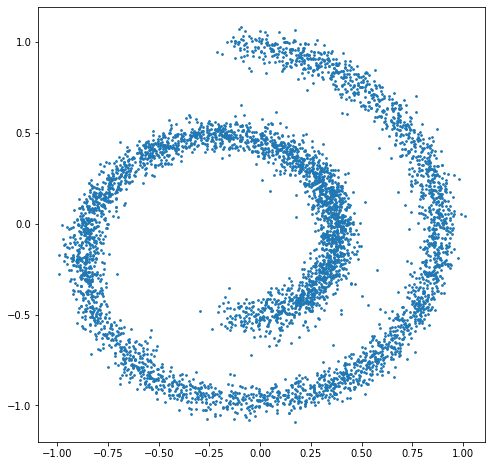

In [15]:
x = sample_vae(5000, ebm, pretrained_vae, num_steps=100, step_size=0.005)
plt.figure(figsize=(8, 8))
plt.scatter(x[:, 0], x[:, 1], s=3)
plt.show()

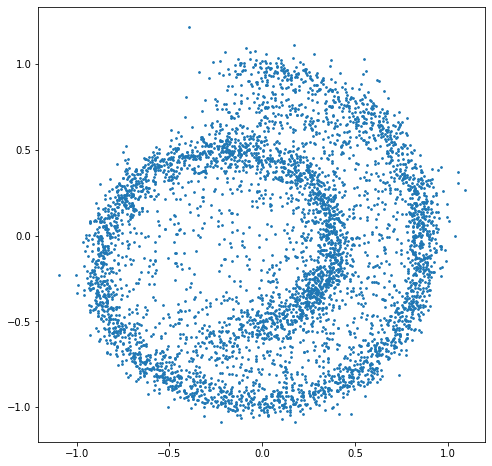

In [ ]:
z = torch.randn(5000, 2)
px_loc, px_std = vae.dec(z).chunk(2, 1)
px = Normal(px_loc, std_fn(px_std))

x = px.sample().detach().cpu().numpy()
plt.figure(figsize=(8, 8))
plt.scatter(x[:, 0], x[:, 1], s=3)
plt.show()